In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
import tldextract
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [351]:
df=pd.read_csv('malicious_phish.csv')

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [353]:
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [354]:
#nema NA vrednosti
df.isna().sum()

url     0
type    0
dtype: int64

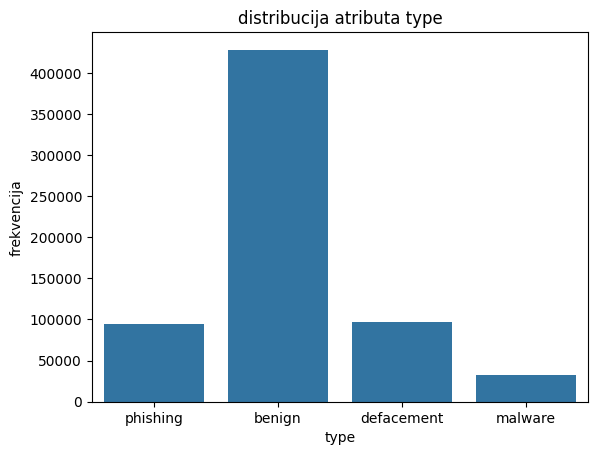

In [355]:
#raspodela 
sns.countplot(x='type',data=df)
plt.xlabel('type')
plt.ylabel('frekvencija')
plt.title('distribucija atributa type')
plt.show()

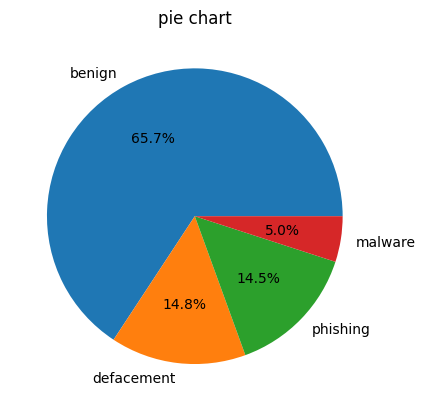

In [356]:
frekv=df['type'].value_counts()
plt.pie(frekv,labels=frekv.index, autopct='%1.1f%%')
plt.title('pie chart')
plt.show()

##ovo ukazuje na nebalansiranost skupa podataka, posebno zbog toga što klasa benign dominira u odnosu na druge klase.

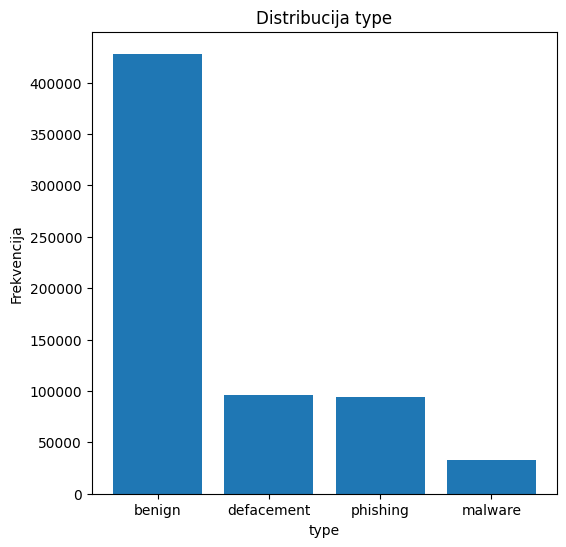

In [357]:
freq=df['type'].value_counts()
plt.figure(figsize=(6,6))
plt.bar(freq.index,freq.values)
plt.xlabel('type')
plt.ylabel('Frekvencija')
plt.title('Distribucija type')
plt.show()


In [358]:
prazni_stringovi = (df == '').sum()
print("\nBroj praznih stringova po kolonama:")
print(prazni_stringovi)


Broj praznih stringova po kolonama:
url     0
type    0
dtype: int64


<h3>Undersampling</h3>

In [359]:
frekv=df['type'].value_counts()

In [360]:
min_frekv=frekv.min()

In [361]:
dfs=[]
for frkv in frekv.index:
    frkv_df=df[df['type']==frkv]
    sampled_frkv=frkv_df.sample(n=min_frekv,random_state=42)
    dfs.append(sampled_frkv)

df_undersampled=pd.concat(dfs)
    

In [362]:
print('Raspodela klasa nakon undersamplinga')
print(df_undersampled['type'].value_counts())

Raspodela klasa nakon undersamplinga
type
benign        32520
defacement    32520
phishing      32520
malware       32520
Name: count, dtype: int64


In [363]:
frekv_undersampled=df_undersampled['type'].value_counts()

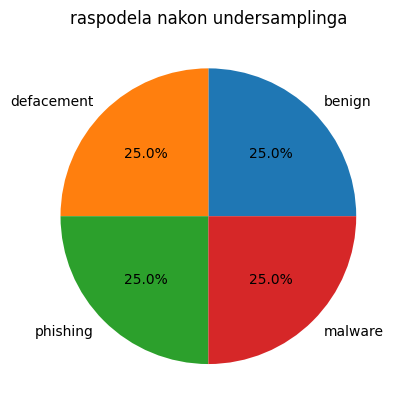

In [364]:
plt.pie(frekv_undersampled,labels=frekv_undersampled.index,autopct='%1.1f%%')
plt.title('raspodela nakon undersamplinga')
plt.show()

<h3>Feature engineering</h3>

<h4>Duzina URL</h4>

In [365]:
df_undersampled['duzina_url']= df_undersampled['url'].apply(len)

In [366]:
mean_length=df_undersampled.groupby('type')['duzina_url'].mean().sort_values()

Text(0, 0.5, 'url length')

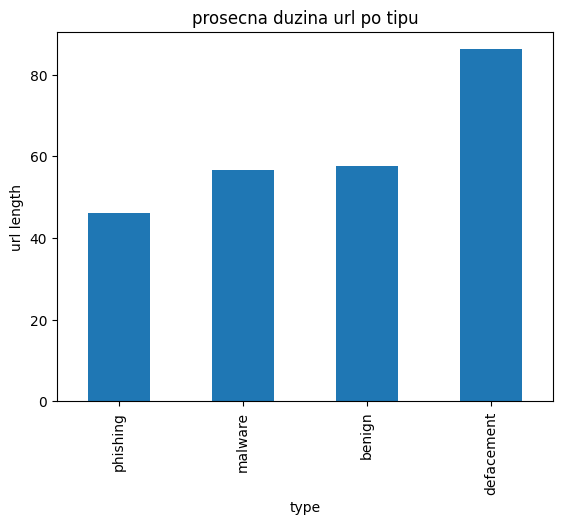

In [367]:
mean_length.plot(kind='bar')
plt.title('prosecna duzina url po tipu')
plt.ylabel('url length')

<h4>Duzina domena</h4>

In [368]:
def duzina_domena(url):
    extracted = tldextract.extract(url)
    
    if extracted.subdomain:
        full_domain = f"{extracted.subdomain}.{extracted.domain}.{extracted.suffix}"
    else:
        full_domain = f"{extracted.domain}.{extracted.suffix}"
    
    return len(full_domain)

In [369]:
df_undersampled['duzina_domena']=df_undersampled['url'].apply(lambda url:duzina_domena(url))

In [370]:
df_undersampled.head(20)

,url,type,duzina_url,duzina_domena
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9
339822,flixster.com/actor/steve-mcqueen,benign,32,12
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17
187420,en.goldenmap.com/City_of_Playford,benign,33,16
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20
153097,music.concordia.ca/,benign,19,18
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16


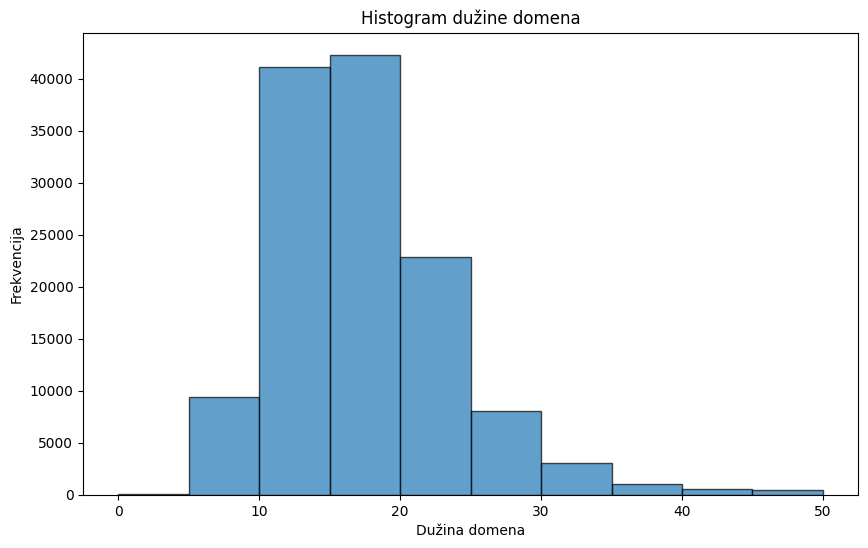

In [371]:
plt.figure(figsize=(10, 6))
plt.hist(df_undersampled['duzina_domena'], bins=10, edgecolor='k', alpha=0.7,range=(0,50))
plt.title('Histogram dužine domena')
plt.xlabel('Dužina domena')
plt.ylabel('Frekvencija')
plt.grid(False)
plt.show()

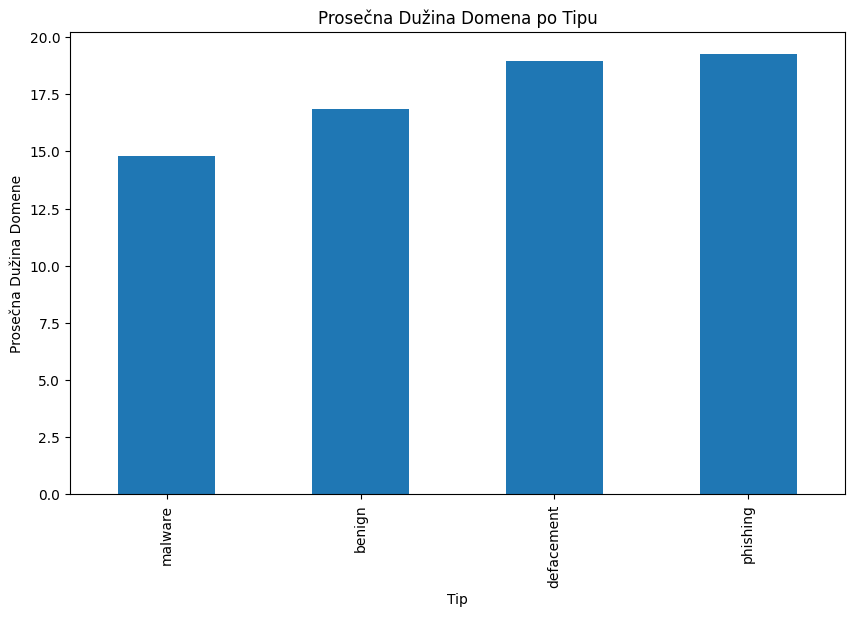

In [372]:
srednja_duzina=df_undersampled.groupby('type')['duzina_domena'].mean().sort_values()
plt.figure(figsize=(10, 6))
srednja_duzina.plot(kind='bar')
plt.title('Prosečna Dužina Domenа po Tipu')
plt.xlabel('Tip')
plt.ylabel('Prosečna Dužina Domene')
plt.show()


In [373]:
df_undersampled.describe()

,duzina_url,duzina_domena
count,130080.000000,130080.00000
mean,61.608933,17.46619
std,42.796276,9.06015
min,1.000000,2.00000
25%,33.000000,13.00000
50%,49.000000,16.00000
75%,81.000000,20.00000
max,1517.000000,239.00000


<h3>Broj tokena u domenu</h3>

In [374]:
def broj_tokena_u_domenu(url):
    
    extracted = tldextract.extract(url)
    
    domain_tokens = [extracted.domain]
    
    
    if extracted.subdomain:
        domain_tokens.insert(0, extracted.subdomain)
    
    
    suffix_tokens = extracted.suffix.split('.')
    domain_tokens.extend(suffix_tokens)
    

    return len(domain_tokens)

In [375]:
df_undersampled['broj_tokena_u_domenu']=df_undersampled['url'].apply(lambda url:broj_tokena_u_domenu(url))

In [376]:
df_undersampled.head(20)

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17,2
187420,en.goldenmap.com/City_of_Playford,benign,33,16,3
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20,3
153097,music.concordia.ca/,benign,19,18,3
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16,3


<h4>Duzina 2nd level domain</h4>

In [377]:
def duzina_2ndleveldomena(url):
    results=tldextract.extract(url)
    return len(results.domain)

In [378]:
df_undersampled['duzina_2nddomena']=df_undersampled['url'].apply(lambda url:duzina_2ndleveldomena(url))

<h4>Duzina subdomena(3rd level domain)</h4>

In [379]:
def duzina_subdomena(url):
    results=tldextract.extract(url)
    return len(results.subdomain)

In [380]:
df_undersampled['duzina_subdomena']=df_undersampled['url'].apply(lambda url:duzina_subdomena(url))

<h4>Duzina TLD</h4>

In [381]:
def duzina_tld(url):
    
    extracted = tldextract.extract(url)
    
    tld = extracted.suffix
   
    return len(tld) if tld else 0

In [382]:
df_undersampled['duzina_tld']=df_undersampled['url'].apply(lambda url:duzina_tld(url))

<h4>Protokol</h4>

In [383]:
def protokol(url):
    return urlparse(url).scheme

In [384]:
df_undersampled['protokol']=df_undersampled['url'].apply(lambda url:protokol(url))

In [385]:
df_undersampled.head(10)

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17,2,13,0,3,http
187420,en.goldenmap.com/City_of_Playford,benign,33,16,3,9,2,3,
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20,3,8,7,3,
153097,music.concordia.ca/,benign,19,18,3,9,5,2,
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16,3,9,2,3,


In [386]:
df_undersampled['protokol'].value_counts()

protokol
http                            65749
                                54870
https                            9437
dbpedia.openlinksw.com              5
activation-pp.3utilities.com        2
gopher.quux.org                     2
www.mit.edu                         2
www-vs.informatik.uni-ulm.de        1
www.ee.ryerson.ca                   1
john.ccac.rwth-aachen.de            1
ww2.ant-nat.com                     1
ilpubs.stanford.edu                 1
www.listhost.net                    1
crib.lehn.org                       1
ftp                                 1
eagle.cch.kcl.ac.uk                 1
pgsql.ru                            1
gwj194.internetdsl.tpnet.pl         1
icscardnl.istmein.de                1
escuelanet.com                      1
Name: count, dtype: int64

<h3>Domen,subdomen,sufiks</h3>

In [387]:
def subdomen(url):
    ext=tldextract.extract(url)
    return ext.subdomain

In [388]:
def domen(url):
    ext=tldextract.extract(url)
    return ext.domain

In [389]:
def sufiks(url):
    ext=tldextract.extract(url)
    return ext.suffix

In [390]:
df_undersampled['subdomen']=df_undersampled['url'].apply(lambda url:subdomen(url))

In [391]:
df_undersampled['domen']=df_undersampled['url'].apply(lambda url:domen(url))

In [392]:
df_undersampled['sufiks']=df_undersampled['url'].apply(lambda url:sufiks(url))

In [393]:
df_undersampled.head(10)

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,domen,sufiks
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,louer,com
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,sol,pt
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,youtube,com
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,uiowa,edu
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,flixster,com
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17,2,13,0,3,http,,stackoverflow,com
187420,en.goldenmap.com/City_of_Playford,benign,33,16,3,9,2,3,,en,goldenmap,com
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20,3,8,7,3,,content,usatoday,com
153097,music.concordia.ca/,benign,19,18,3,9,5,2,,music,concordia,ca
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16,3,9,2,3,,en,wikipedia,org


<h4>Duzina putanje</h4>

In [394]:
def duzina_putanje(url):
   return len(urlparse(url).path)

In [395]:
df_undersampled['duzina_putanje']=df_undersampled['url'].apply(lambda url:duzina_putanje(url))

In [396]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   url                   130080 non-null  object
 1   type                  130080 non-null  object
 2   duzina_url            130080 non-null  int64 
 3   duzina_domena         130080 non-null  int64 
 4   broj_tokena_u_domenu  130080 non-null  int64 
 5   duzina_2nddomena      130080 non-null  int64 
 6   duzina_subdomena      130080 non-null  int64 
 7   duzina_tld            130080 non-null  int64 
 8   protokol              130080 non-null  object
 9   subdomen              130080 non-null  object
 10  domen                 130080 non-null  object
 11  sufiks                130080 non-null  object
 12  duzina_putanje        130080 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 13.9+ MB


In [397]:
prosecna_duzina_putanje=df_undersampled.groupby('type')['duzina_putanje'].mean().sort_values()

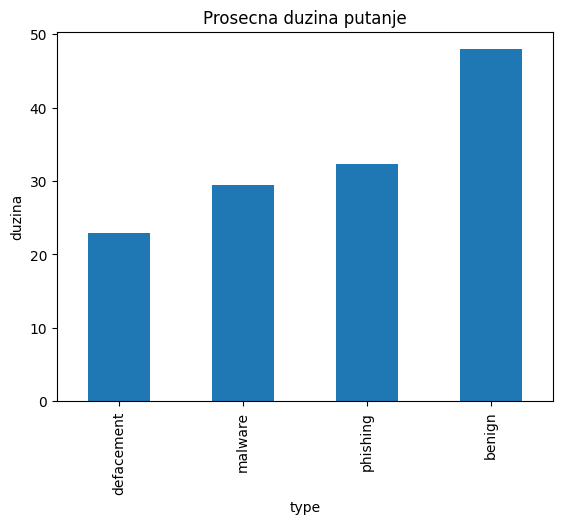

In [398]:
prosecna_duzina_putanje.plot(kind='bar')
plt.title('Prosecna duzina putanje')
plt.xlabel('type')
plt.ylabel('duzina')
plt.show()

<h4>Broj tokena u putanji</h4>

In [399]:
def broj_tokena_u_putanji(url):
    parsed_url = urlparse(url.lower())
    path = parsed_url.path
    path_tokens = path.strip('/').split('/')
    return len(path_tokens)

In [400]:
df_undersampled['broj_tokena_u_putanji']=df_undersampled['url'].apply(lambda url:broj_tokena_u_putanji(url))

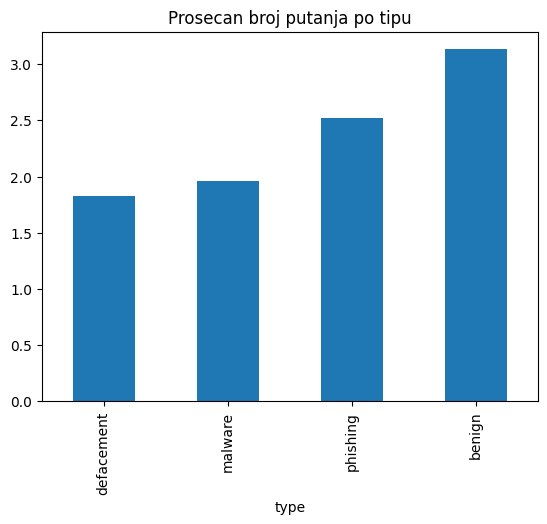

In [401]:
prosecan_broj_putanja=df_undersampled.groupby('type')['broj_tokena_u_putanji'].mean().sort_values()
prosecan_broj_putanja.plot(kind='bar')
plt.title('Prosecan broj putanja po tipu')
plt.show()

<h4>Da li URL sadrzi ip adresu?</h4>

In [402]:
def sadrzi_ip_addresu(url):
    # Regularni izrazi za IPv4 i IPv6
    ipv4_pattern = (
        r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    )
    ipv6_pattern = (
        r'\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b|'  # Standardni IPv6
        r'(?:[0-9a-fA-F]{1,4}:){1,7}:|'                      # Uncured IPv6
        r'(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|'
        r'(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|'
        r'(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|'
        r'(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|'
        r'(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|'
        r'[0-9a-fA-F]{1,4}:(?::[0-9a-fA-F]{1,4}){1,6}|'
        r'(?::(?::[0-9a-fA-F]{1,4}){1,7}|'
        r'::[0-9a-fA-F]{1,4}){1,7}\b'
    )
    
    # Kombinovani regularni izraz
    pattern = f'{ipv4_pattern}|{ipv6_pattern}'
    
    # Parsirajte URL i izvadite hostname
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    
    if hostname:
        # Pretražimo hostname za IP adrese
        match = re.search(pattern, hostname)
        return 1 if match else 0
    else:
        return 0


In [403]:
df_undersampled['sadrzi_ip_adresu']=df_undersampled['url'].apply(sadrzi_ip_addresu)

In [404]:
df_undersampled[df_undersampled['sadrzi_ip_adresu']==1].head()

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,domen,sufiks,duzina_putanje,broj_tokena_u_putanji,sadrzi_ip_adresu
110247,http://66.184.94.210/paypal/finish.php,phishing,38,14,2,13,0,0,http,,66.184.94.210,,18,2,1
256043,http://27.120.84.31/~kanfitbu/properties/remax/,phishing,47,13,2,12,0,0,http,,27.120.84.31,,28,3,1
526927,http://66.45.251.211/,phishing,21,14,2,13,0,0,http,,66.45.251.211,,1,1,1
531320,http://185.177.54.1/TP/public/index.php,phishing,39,13,2,12,0,0,http,,185.177.54.1,,20,3,1
524413,http://175.107.206.134/wp-content/plugins/rbcb...,phishing,172,16,2,15,0,0,http,,175.107.206.134,,43,4,1


In [405]:
print(pd.crosstab(df_undersampled['type'],df_undersampled['sadrzi_ip_adresu']))

sadrzi_ip_adresu      0      1
type                          
benign            32520      0
defacement        32520      0
malware           20761  11759
phishing          32414    106


<h4>Da li sadrzi parametre</h4>

In [406]:
def sadrzi_parametre(url):
    return int(bool(urlparse(url).params))

In [407]:
df_undersampled['sadrzi_parametre']=df_undersampled['url'].apply(lambda url:sadrzi_parametre(url))

<h4>Da li sadrzi upit</h4>

In [408]:
def sadrzi_upit(url):
    return int(bool(urlparse(url).query))

In [409]:
df_undersampled['sadrzi_upit']=df_undersampled['url'].apply(lambda url:sadrzi_upit(url))

In [410]:
df_undersampled.head(15)

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,domen,sufiks,duzina_putanje,broj_tokena_u_putanji,sadrzi_ip_adresu,sadrzi_parametre,sadrzi_upit
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,louer,com,48,3,0,0,0
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,sol,pt,44,4,0,0,0
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,youtube,com,17,2,0,0,1
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,uiowa,edu,30,3,0,0,0
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,flixster,com,32,3,0,0,0
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17,2,13,0,3,http,,stackoverflow,com,81,3,0,0,0
187420,en.goldenmap.com/City_of_Playford,benign,33,16,3,9,2,3,,en,goldenmap,com,33,2,0,0,0
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20,3,8,7,3,,content,usatoday,com,46,4,0,0,1
153097,music.concordia.ca/,benign,19,18,3,9,5,2,,music,concordia,ca,19,1,0,0,0
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16,3,9,2,3,,en,wikipedia,org,45,3,0,0,0


In [411]:
from googlesearch import search

In [412]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0

In [413]:
df_undersampled['google_index'] = df_undersampled['url'].apply(lambda i: google_index(i))

In [414]:
df_undersampled['google_index'].value_counts()

google_index
1    130080
Name: count, dtype: int64

In [415]:
df_undersampled.drop('google_index',axis=1,inplace=True)

In [416]:
df_undersampled.head(20)

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,domen,sufiks,duzina_putanje,broj_tokena_u_putanji,sadrzi_ip_adresu,sadrzi_parametre,sadrzi_upit
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,louer,com,48,3,0,0,0
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,sol,pt,44,4,0,0,0
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,youtube,com,17,2,0,0,1
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,uiowa,edu,30,3,0,0,0
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,flixster,com,32,3,0,0,0
174885,http://stackoverflow.com/questions/5069876/reg...,benign,105,17,2,13,0,3,http,,stackoverflow,com,81,3,0,0,0
187420,en.goldenmap.com/City_of_Playford,benign,33,16,3,9,2,3,,en,goldenmap,com,33,2,0,0,0
434789,content.usatoday.com/community/tags/topic.aspx...,benign,71,20,3,8,7,3,,content,usatoday,com,46,4,0,0,1
153097,music.concordia.ca/,benign,19,18,3,9,5,2,,music,concordia,ca,19,1,0,0,0
50095,en.wikipedia.org/wiki/Aveos_Fleet_Performance,benign,45,16,3,9,2,3,,en,wikipedia,org,45,3,0,0,0


<h4> Da li sadrzi sumnjive reci? </h4>

In [417]:
sadrzi_sumnjive_reci = ['confirm', 'account', 'banking', 'secure', 'ebayisapi', 'webscr', 'login', 'signin','free','service','bonus','PayPal','update','free','lucky']
,
def contains_security_sensitive_words(url):
    return int(any(word in url.lower() for word in sadrzi_sumnjive_reci))

df_undersampled['sadrzi_sumnjive_reci'] = df_undersampled['url'].apply(lambda url:contains_security_sensitive_words(url))

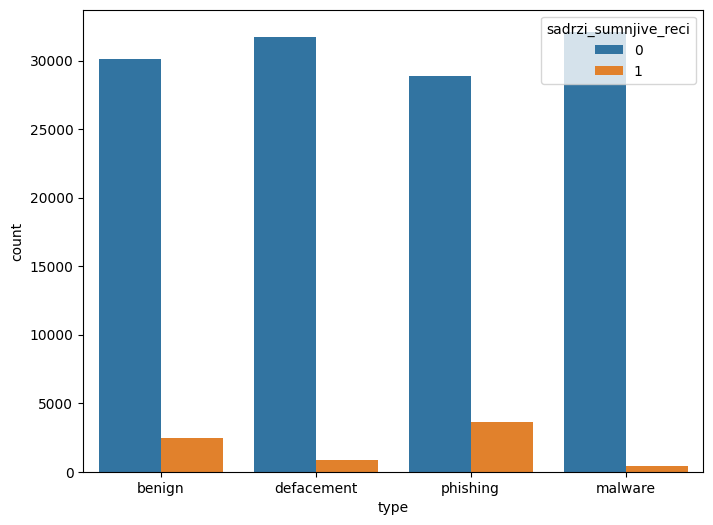

In [418]:
plt.figure(figsize=(8, 6))
sns.countplot(df_undersampled,x='type',hue='sadrzi_sumnjive_reci')
plt.show()

<h4>HTTP I HTTPS</h4>

In [419]:
def broji_http(url):
    return url.count('http')

In [420]:
df_undersampled['broj_http']=df_undersampled['url'].apply(lambda url:broji_http(url))

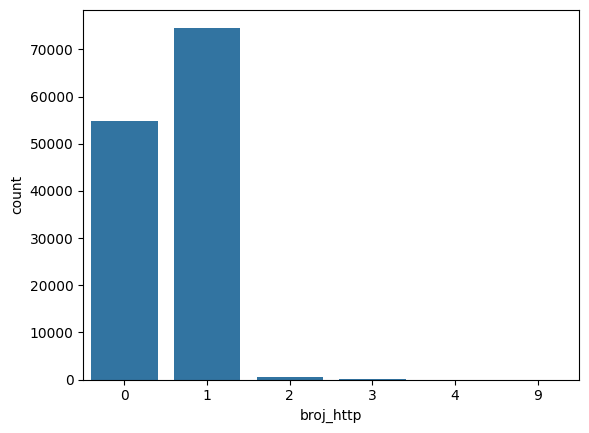

In [421]:
sns.countplot(x='broj_http',data=df_undersampled)
plt.show()


In [422]:
def broji_https(url):
    return url.count('https')

In [423]:
df_undersampled['broj_https']=df_undersampled['url'].apply(lambda url:broji_https(url))

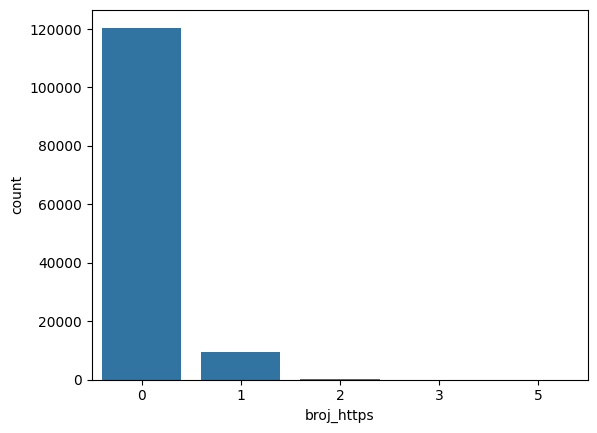

In [424]:
sns.countplot(x='broj_https',data=df_undersampled)
plt.show()


<h4>Prebrojavanje pojavljivanja specijalnih karaktera</h4>

In [425]:
def broj_at(url):
    return url.count('@')

In [426]:
df_undersampled['broj@']=df_undersampled['url'].apply(lambda x:broj_at(x))

In [427]:
def broj_dir(url):
    return url.count('/')

In [428]:
df_undersampled['broj/']=df_undersampled['url'].apply(lambda x:broj_dir(x))

In [429]:
def broj_dir2(url):
    return url.count('//')

In [430]:
df_undersampled['broj//']=df_undersampled['url'].apply(lambda x:broj_dir2(x))

In [431]:
def broj_procenat(url):
    return url.count('%')

In [432]:
df_undersampled['broj_procenat']=df_undersampled['url'].apply(lambda x:broj_procenat(x))

In [433]:
def broj_upitnik(url):
    return url.count('?')

In [434]:
df_undersampled['broj_upitnik']=df_undersampled['url'].apply(lambda x:broj_upitnik(x))

In [435]:
def broj_crtica(url):
    return url.count('-')

In [436]:
df_undersampled['broj_crtica']=df_undersampled['url'].apply(lambda x:broj_crtica(x))

In [437]:
def broj_www(url):
    return url.count("www")

In [438]:
df_undersampled['broj_www']=df_undersampled['url'].apply(lambda x:broj_www(x))

In [439]:
df_undersampled.head()

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,...,sadrzi_sumnjive_reci,broj_http,broj_https,broj@,broj/,broj//,broj_procenat,broj_upitnik,broj_crtica,broj_www
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,...,0,0,0,0,3,0,0,0,2,0
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,...,0,0,0,0,3,0,0,0,0,0
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,...,0,0,0,0,1,0,0,1,0,0
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,...,0,0,0,0,3,0,0,0,0,0
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,...,0,0,0,0,2,0,0,0,1,0


<h3>Vizualizacija</h3>

In [440]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   url                    130080 non-null  object
 1   type                   130080 non-null  object
 2   duzina_url             130080 non-null  int64 
 3   duzina_domena          130080 non-null  int64 
 4   broj_tokena_u_domenu   130080 non-null  int64 
 5   duzina_2nddomena       130080 non-null  int64 
 6   duzina_subdomena       130080 non-null  int64 
 7   duzina_tld             130080 non-null  int64 
 8   protokol               130080 non-null  object
 9   subdomen               130080 non-null  object
 10  domen                  130080 non-null  object
 11  sufiks                 130080 non-null  object
 12  duzina_putanje         130080 non-null  int64 
 13  broj_tokena_u_putanji  130080 non-null  int64 
 14  sadrzi_ip_adresu       130080 non-null  int64 
 15  

In [441]:
df_undersampled.describe()

,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,duzina_putanje,broj_tokena_u_putanji,sadrzi_ip_adresu,sadrzi_parametre,...,sadrzi_sumnjive_reci,broj_http,broj_https,broj@,broj/,broj//,broj_procenat,broj_upitnik,broj_crtica,broj_www
count,130080.000000,130080.00000,130080.000000,130080.00000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,...,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000,130080.000000
mean,61.608933,17.46619,2.559348,10.14315,3.048178,2.798524,33.159525,2.358933,0.091213,0.001415,...,0.056273,0.586224,0.074408,0.002791,3.314906,0.583172,0.911631,0.245764,1.109794,0.310494
std,42.796276,9.06015,0.597801,5.01576,7.780553,1.296572,26.509985,1.519431,0.287913,0.037584,...,0.230449,0.510146,0.265811,0.054895,1.905717,0.504336,4.873329,0.447028,2.380892,0.466520
min,1.000000,2.00000,2.000000,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,13.00000,2.000000,6.00000,0.000000,2.000000,13.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,16.00000,3.000000,9.00000,0.000000,3.000000,27.000000,2.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,81.000000,20.00000,3.000000,13.00000,3.000000,3.000000,45.000000,3.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1517.000000,239.00000,5.000000,110.00000,226.000000,15.000000,1008.000000,22.000000,1.000000,1.000000,...,1.000000,9.000000,5.000000,3.000000,32.000000,9.000000,146.000000,17.000000,36.000000,4.000000


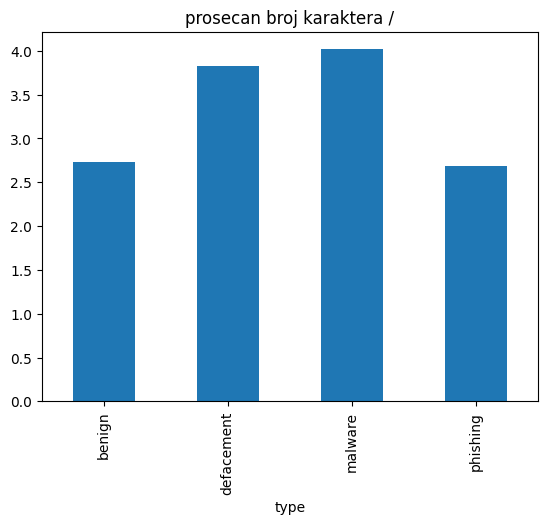

In [442]:
prosecan_broj=df_undersampled.groupby('type')['broj/'].mean()
prosecan_broj.plot(kind='bar')
plt.title('prosecan broj karaktera /')
plt.show()

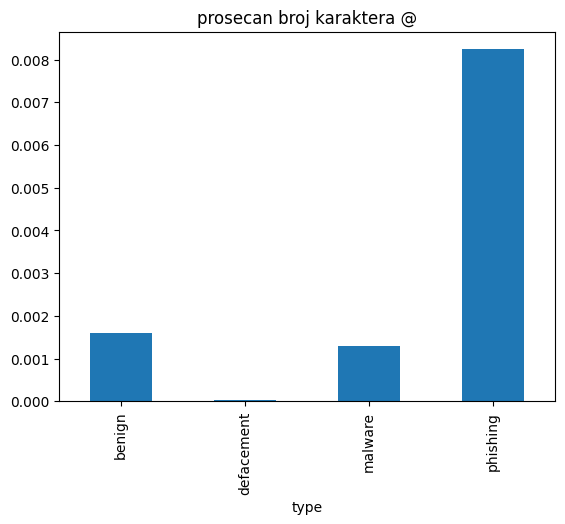

In [443]:
prosecan_broj=df_undersampled.groupby('type')['broj@'].mean()
prosecan_broj.plot(kind='bar')
plt.title('prosecan broj karaktera @')
plt.show()

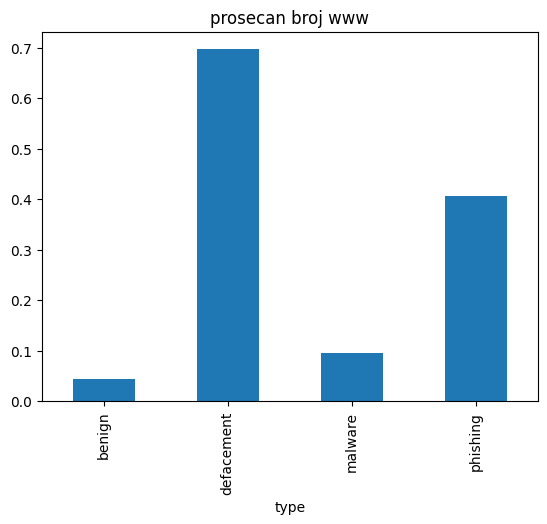

In [444]:
prosecan_broj=df_undersampled.groupby('type')['broj_www'].mean()
prosecan_broj.plot(kind='bar')
plt.title('prosecan broj www')
plt.show()

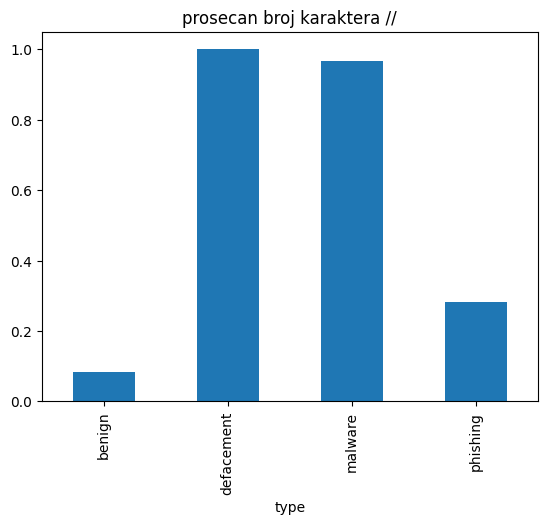

In [445]:
prosecan_broj=df_undersampled.groupby('type')['broj//'].mean()
prosecan_broj.plot(kind='bar')
plt.title('prosecan broj karaktera //')
plt.show()

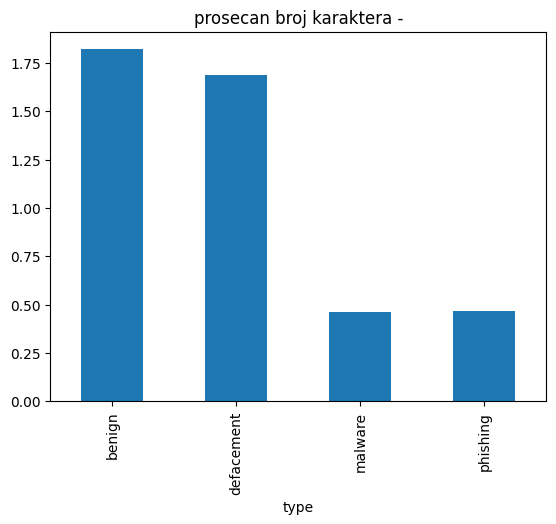

In [446]:
prosek=df_undersampled.groupby('type')['broj_crtica'].mean()
prosek.plot(kind='bar')
plt.title('prosecan broj karaktera -')
plt.show()

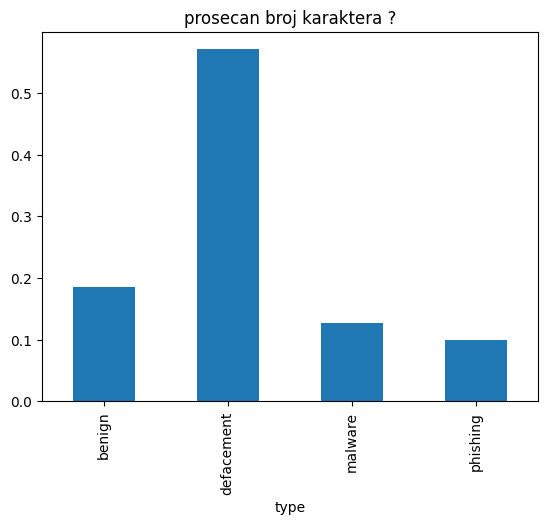

In [447]:
prosek=df_undersampled.groupby('type')['broj_upitnik'].mean()
prosek.plot(kind='bar')
plt.title('prosecan broj karaktera ?')
plt.show()

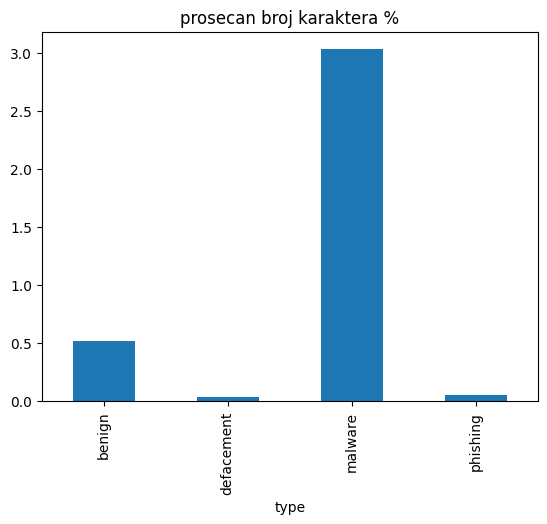

In [448]:
prosek=df_undersampled.groupby('type')['broj_procenat'].mean()
prosek.plot(kind='bar')
plt.title('prosecan broj karaktera %')
plt.show()

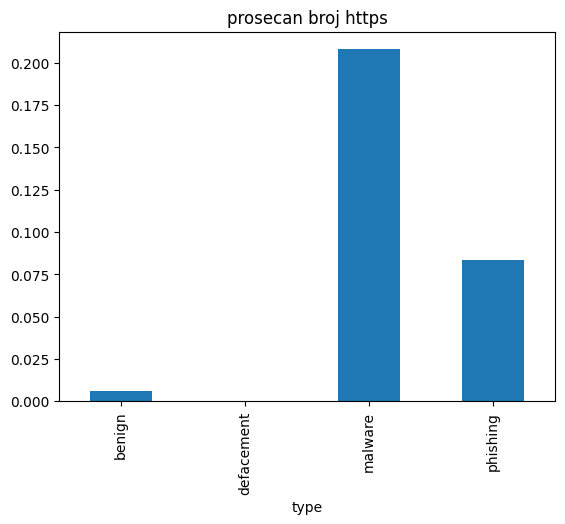

In [449]:
prosek=df_undersampled.groupby('type')['broj_https'].mean()
prosek.plot(kind='bar')
plt.title('prosecan broj https')
plt.show()

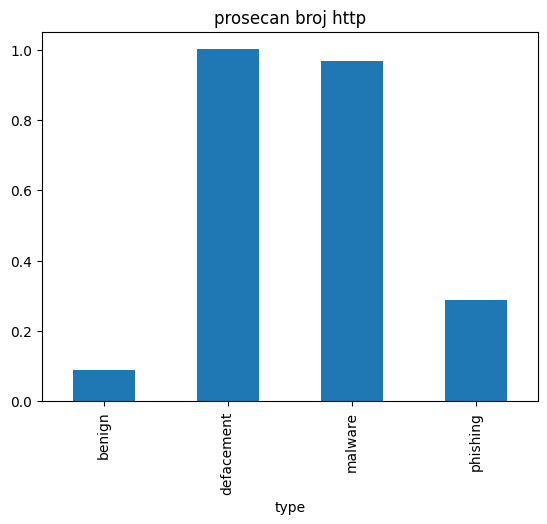

In [450]:
prosek=df_undersampled.groupby('type')['broj_http'].mean()
prosek.plot(kind='bar')
plt.title('prosecan broj http')
plt.show()

In [451]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   url                    130080 non-null  object
 1   type                   130080 non-null  object
 2   duzina_url             130080 non-null  int64 
 3   duzina_domena          130080 non-null  int64 
 4   broj_tokena_u_domenu   130080 non-null  int64 
 5   duzina_2nddomena       130080 non-null  int64 
 6   duzina_subdomena       130080 non-null  int64 
 7   duzina_tld             130080 non-null  int64 
 8   protokol               130080 non-null  object
 9   subdomen               130080 non-null  object
 10  domen                  130080 non-null  object
 11  sufiks                 130080 non-null  object
 12  duzina_putanje         130080 non-null  int64 
 13  broj_tokena_u_putanji  130080 non-null  int64 
 14  sadrzi_ip_adresu       130080 non-null  int64 
 15  

In [452]:
numericalfeatures=df_undersampled.select_dtypes(include='int64')

In [453]:
numericalfeatures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   duzina_url             130080 non-null  int64
 1   duzina_domena          130080 non-null  int64
 2   broj_tokena_u_domenu   130080 non-null  int64
 3   duzina_2nddomena       130080 non-null  int64
 4   duzina_subdomena       130080 non-null  int64
 5   duzina_tld             130080 non-null  int64
 6   duzina_putanje         130080 non-null  int64
 7   broj_tokena_u_putanji  130080 non-null  int64
 8   sadrzi_ip_adresu       130080 non-null  int64
 9   sadrzi_parametre       130080 non-null  int64
 10  sadrzi_upit            130080 non-null  int64
 11  sadrzi_sumnjive_reci   130080 non-null  int64
 12  broj_http              130080 non-null  int64
 13  broj_https             130080 non-null  int64
 14  broj@                  130080 non-null  int64
 15  broj/            

In [454]:
cormatrix=numericalfeatures.corr()

<Axes: >

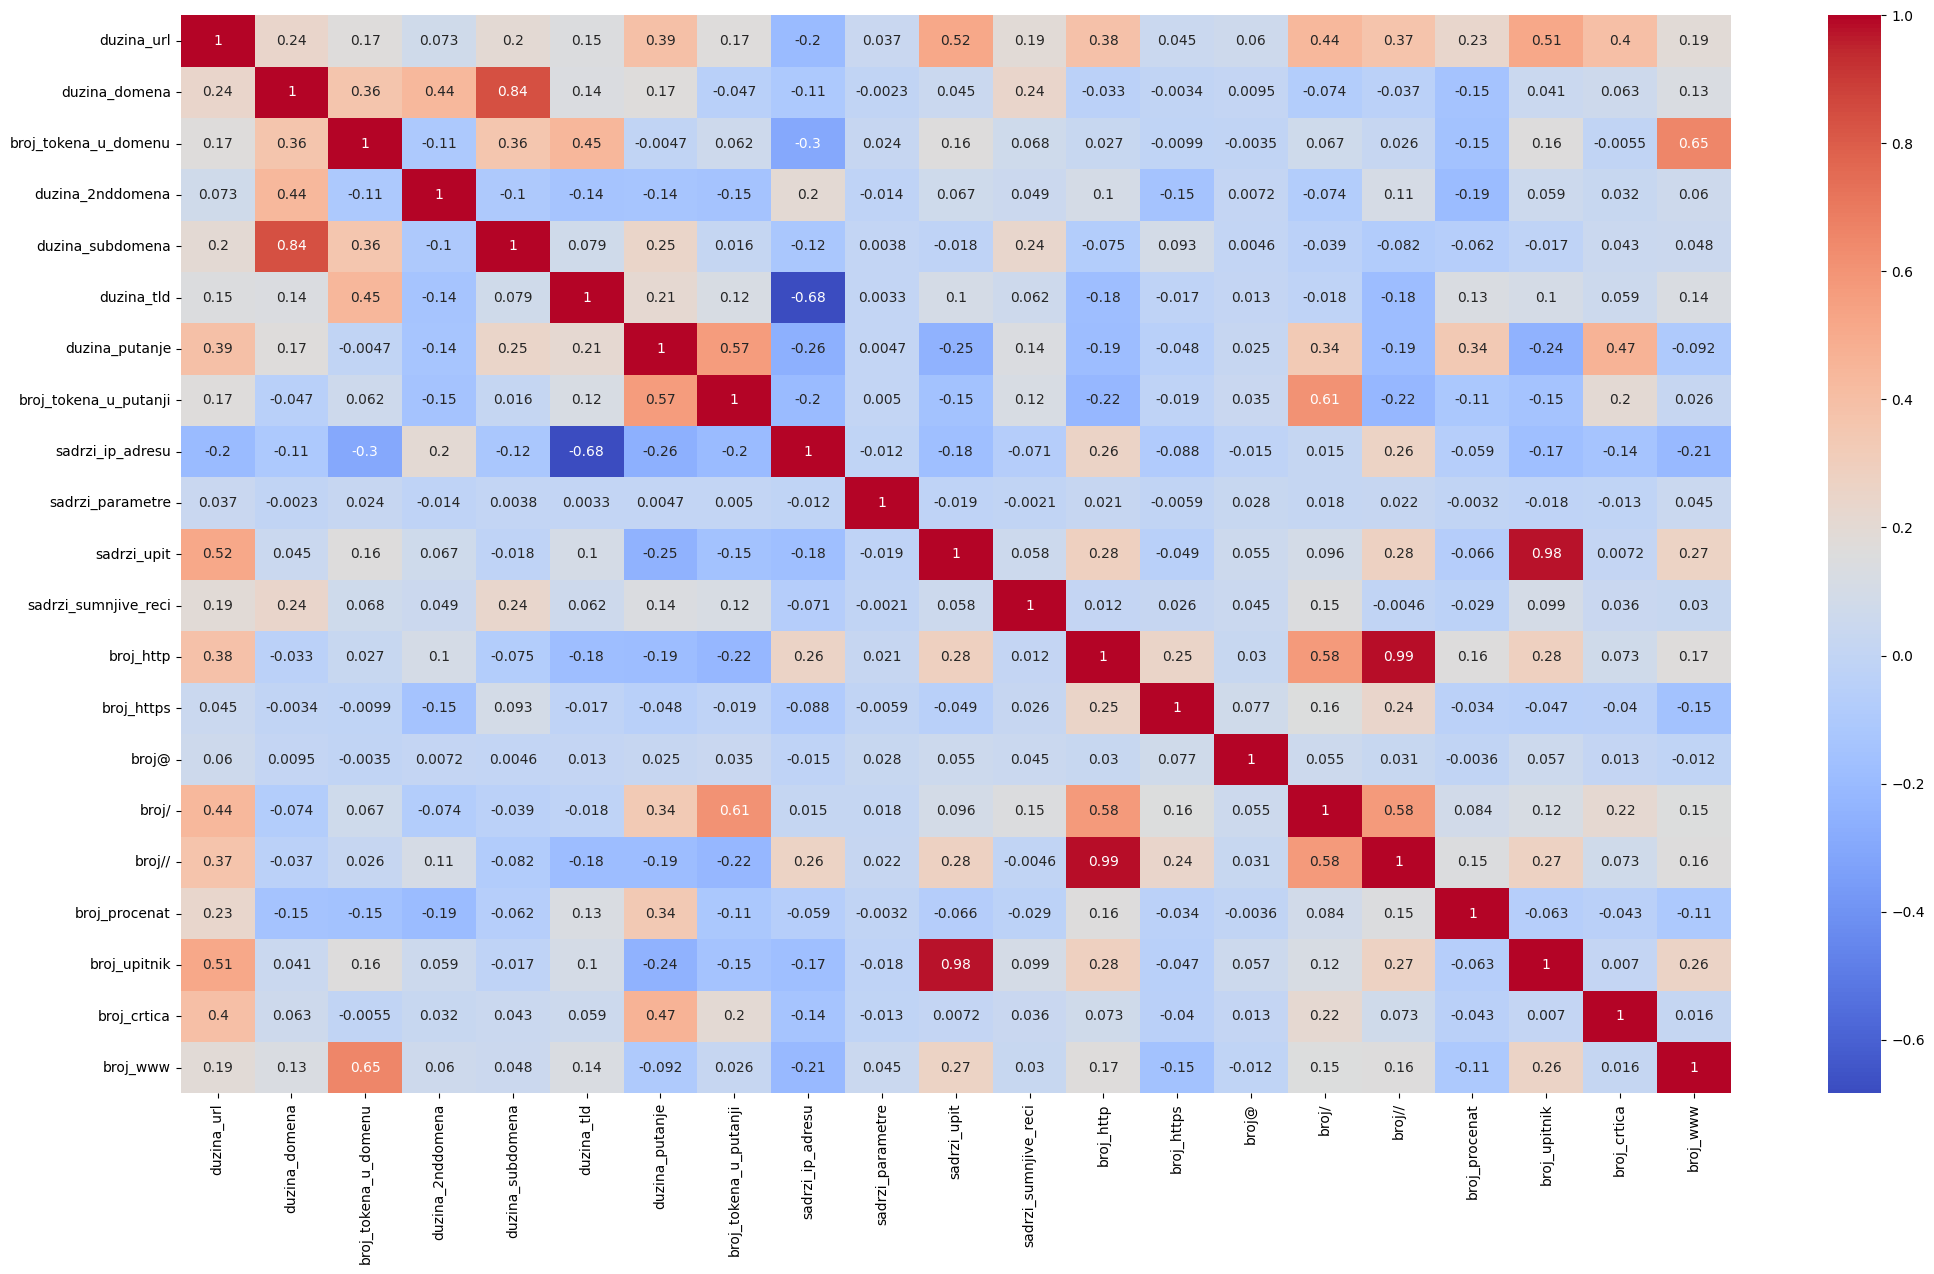

In [455]:
plt.figure(figsize=(25,14))
sns.heatmap(cormatrix,annot=True,cmap='coolwarm')

<h3>Ima ip adresu</h3>

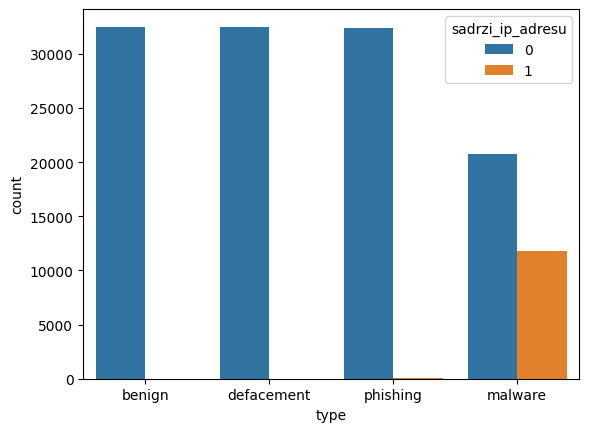

In [456]:
sns.countplot(x='type',hue='sadrzi_ip_adresu',data=df_undersampled)
plt.show()

<h3>Sadrzi login, parametre, upit?</h3>

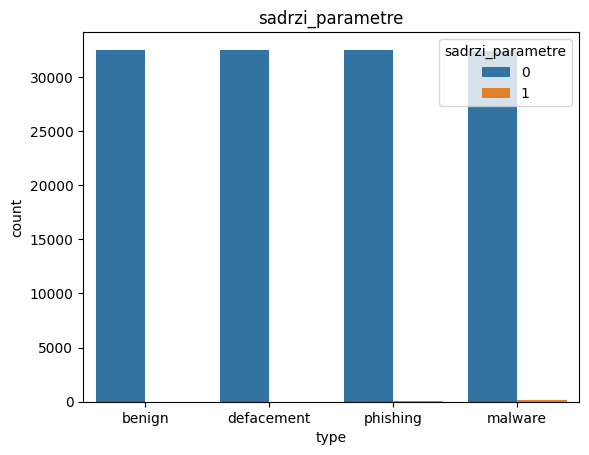

In [457]:
sns.countplot(x='type',hue='sadrzi_parametre',data=df_undersampled)
plt.title('sadrzi_parametre')
plt.show()

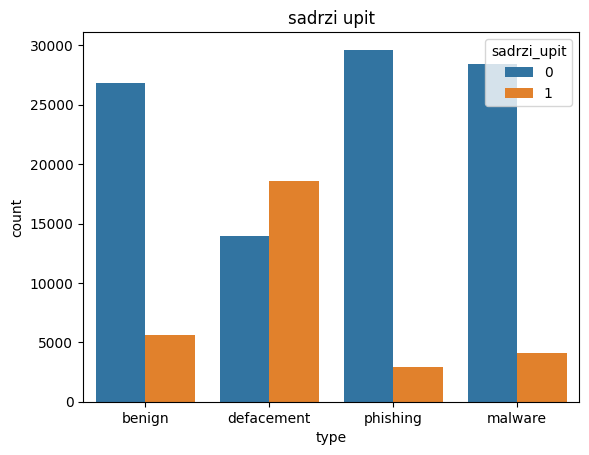

In [458]:
sns.countplot(x='type',hue='sadrzi_upit',data=df_undersampled)
plt.title('sadrzi upit')
plt.show()

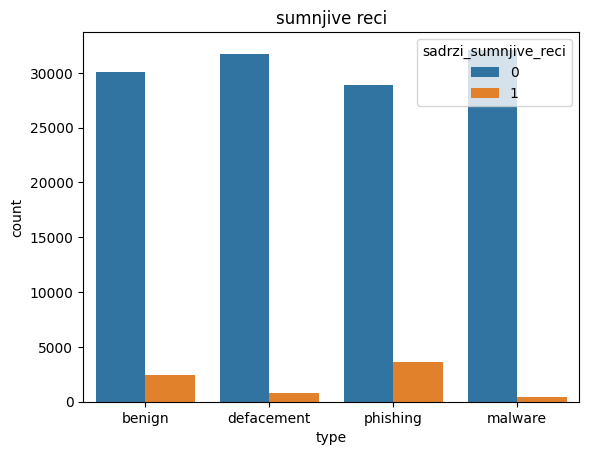

In [459]:
sns.countplot(x='type',hue='sadrzi_sumnjive_reci',data=df_undersampled)
plt.title('sumnjive reci')
plt.show()

In [460]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   url                    130080 non-null  object
 1   type                   130080 non-null  object
 2   duzina_url             130080 non-null  int64 
 3   duzina_domena          130080 non-null  int64 
 4   broj_tokena_u_domenu   130080 non-null  int64 
 5   duzina_2nddomena       130080 non-null  int64 
 6   duzina_subdomena       130080 non-null  int64 
 7   duzina_tld             130080 non-null  int64 
 8   protokol               130080 non-null  object
 9   subdomen               130080 non-null  object
 10  domen                  130080 non-null  object
 11  sufiks                 130080 non-null  object
 12  duzina_putanje         130080 non-null  int64 
 13  broj_tokena_u_putanji  130080 non-null  int64 
 14  sadrzi_ip_adresu       130080 non-null  int64 
 15  

<h3>Duzina URL, domena, TLD</h3>

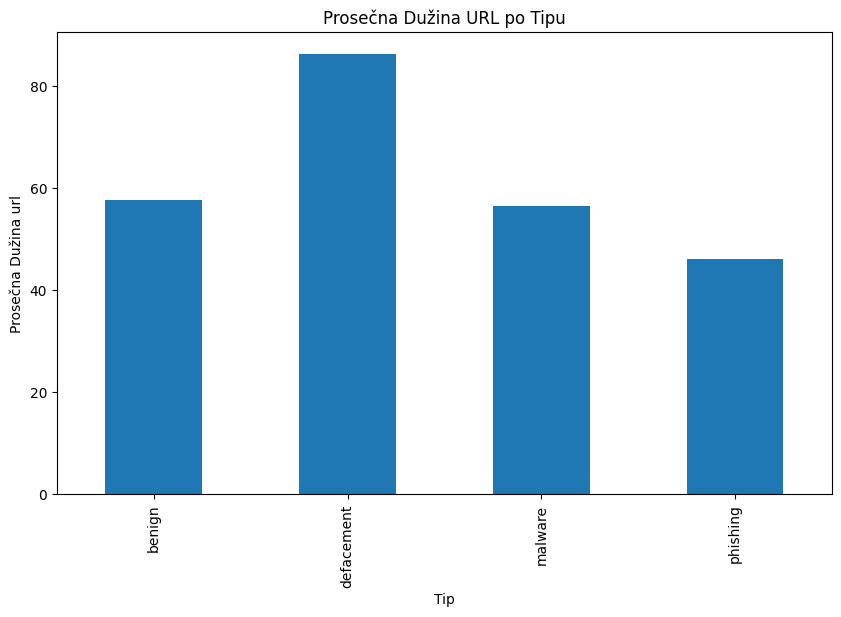

In [461]:
prosecna_duzina=df_undersampled.groupby('type')['duzina_url'].mean()
plt.figure(figsize=(10, 6))
prosecna_duzina.plot(kind='bar')
plt.title('Prosečna Dužina URL po Tipu')
plt.xlabel('Tip')
plt.ylabel('Prosečna Dužina url')
plt.show()


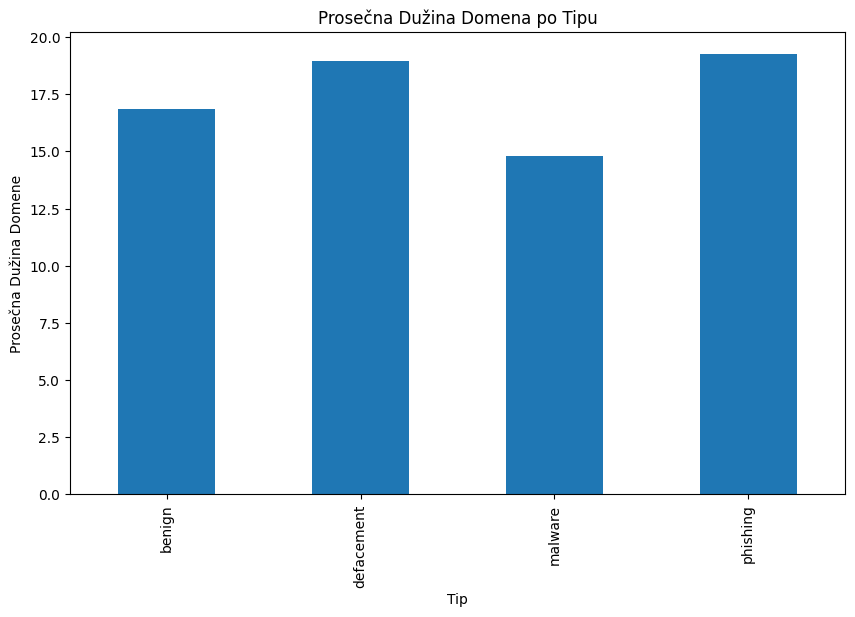

In [462]:
prosecna_duzina=df_undersampled.groupby('type')['duzina_domena'].mean()
plt.figure(figsize=(10, 6))
prosecna_duzina.plot(kind='bar')
plt.title('Prosečna Dužina Domenа po Tipu')
plt.xlabel('Tip')
plt.ylabel('Prosečna Dužina Domene')
plt.show()


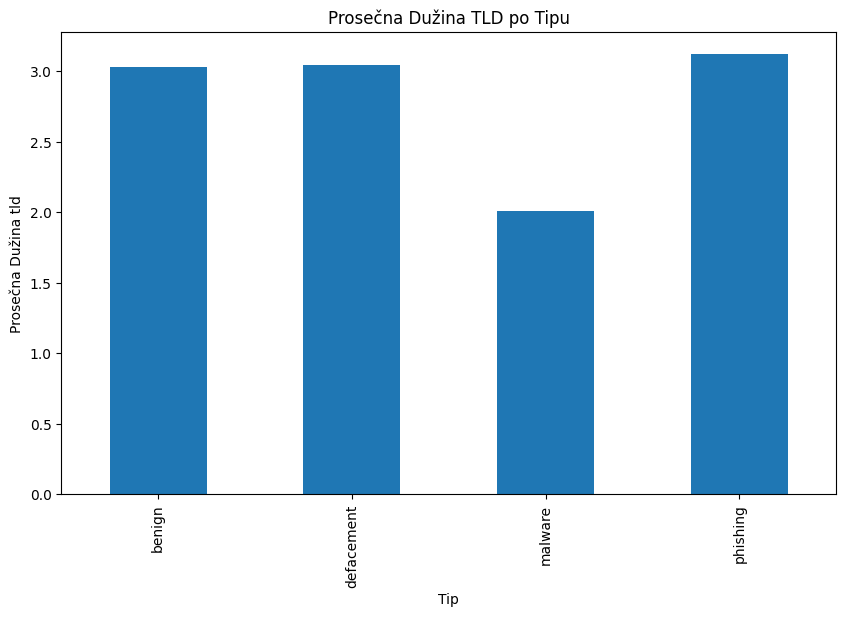

In [463]:
prosecna_duzina=df_undersampled.groupby('type')['duzina_tld'].mean()
plt.figure(figsize=(10, 6))
prosecna_duzina.plot(kind='bar')
plt.title('Prosečna Dužina TLD po Tipu')
plt.xlabel('Tip')
plt.ylabel('Prosečna Dužina tld')
plt.show()


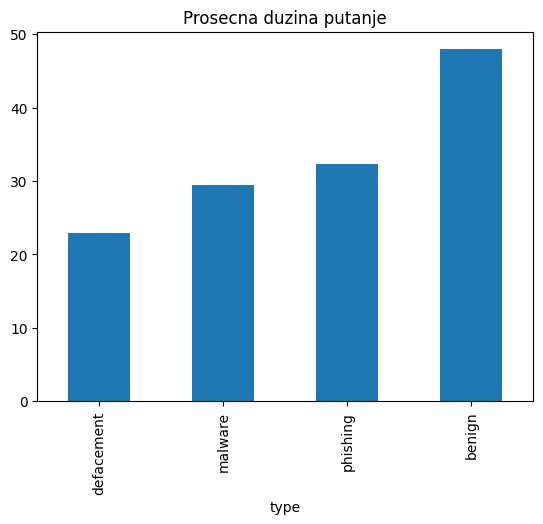

In [464]:
prosecna_putanja=df_undersampled.groupby('type')['duzina_putanje'].mean()
prosecna_duzina_putanje.plot(kind='bar')
plt.title('Prosecna duzina putanje')
plt.show()

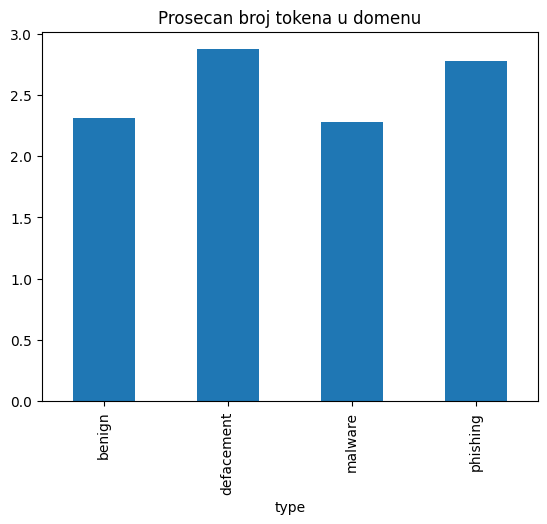

In [465]:
prosecan_broj_tokena_u_domenu=df_undersampled.groupby('type')['broj_tokena_u_domenu'].mean()
prosecan_broj_tokena_u_domenu.plot(kind='bar')
plt.title('Prosecan broj tokena u domenu')
plt.show()

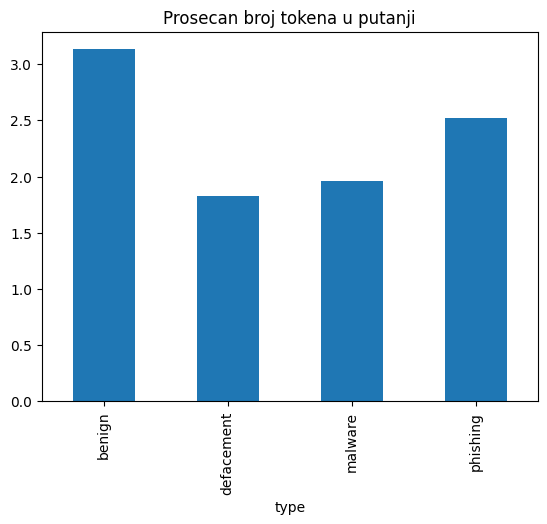

In [466]:
broj_tokena_u_putanji=df_undersampled.groupby('type')['broj_tokena_u_putanji'].mean()
broj_tokena_u_putanji.plot(kind='bar')
plt.title('Prosecan broj tokena u putanji')
plt.show()

In [467]:
df_undersampled.head()

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,...,sadrzi_sumnjive_reci,broj_http,broj_https,broj@,broj/,broj//,broj_procenat,broj_upitnik,broj_crtica,broj_www
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,...,0,0,0,0,3,0,0,0,2,0
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,...,0,0,0,0,3,0,0,0,0,0
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,...,0,0,0,0,1,0,0,1,0,0
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,...,0,0,0,0,3,0,0,0,0,0
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,...,0,0,0,0,2,0,0,0,1,0


<h3>Label Encoding</h3>

In [468]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   url                    130080 non-null  object
 1   type                   130080 non-null  object
 2   duzina_url             130080 non-null  int64 
 3   duzina_domena          130080 non-null  int64 
 4   broj_tokena_u_domenu   130080 non-null  int64 
 5   duzina_2nddomena       130080 non-null  int64 
 6   duzina_subdomena       130080 non-null  int64 
 7   duzina_tld             130080 non-null  int64 
 8   protokol               130080 non-null  object
 9   subdomen               130080 non-null  object
 10  domen                  130080 non-null  object
 11  sufiks                 130080 non-null  object
 12  duzina_putanje         130080 non-null  int64 
 13  broj_tokena_u_putanji  130080 non-null  int64 
 14  sadrzi_ip_adresu       130080 non-null  int64 
 15  

In [469]:
df_undersampled.head()

,url,type,duzina_url,duzina_domena,broj_tokena_u_domenu,duzina_2nddomena,duzina_subdomena,duzina_tld,protokol,subdomen,...,sadrzi_sumnjive_reci,broj_http,broj_https,broj@,broj/,broj//,broj_procenat,broj_upitnik,broj_crtica,broj_www
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,48,18,3,5,8,3,,montreal,...,0,0,0,0,3,0,0,0,2,0
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,44,17,3,3,10,2,,comunidade,...,0,0,0,0,3,0,0,0,0,0
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,31,11,2,7,0,3,,,...,0,0,0,0,1,0,0,1,0,0
50193,uiowa.edu/~acadtech/phonetics/,benign,30,9,2,5,0,3,,,...,0,0,0,0,3,0,0,0,0,0
339822,flixster.com/actor/steve-mcqueen,benign,32,12,2,8,0,3,,,...,0,0,0,0,2,0,0,0,1,0


In [470]:
labelEncoder = LabelEncoder()
df_undersampled["type"] = labelEncoder.fit_transform(df_undersampled["type"])

In [471]:
print(labelEncoder.classes_)
#benign → 0
#defacement → 1
#malware → 2
#phishing → 3


['benign' 'defacement' 'malware' 'phishing']


In [472]:
df_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130080 entries, 514768 to 546320
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   url                    130080 non-null  object
 1   type                   130080 non-null  int32 
 2   duzina_url             130080 non-null  int64 
 3   duzina_domena          130080 non-null  int64 
 4   broj_tokena_u_domenu   130080 non-null  int64 
 5   duzina_2nddomena       130080 non-null  int64 
 6   duzina_subdomena       130080 non-null  int64 
 7   duzina_tld             130080 non-null  int64 
 8   protokol               130080 non-null  object
 9   subdomen               130080 non-null  object
 10  domen                  130080 non-null  object
 11  sufiks                 130080 non-null  object
 12  duzina_putanje         130080 non-null  int64 
 13  broj_tokena_u_putanji  130080 non-null  int64 
 14  sadrzi_ip_adresu       130080 non-null  int64 
 15  

In [473]:
X=df_undersampled[['duzina_url','duzina_domena','broj_tokena_u_domenu','duzina_2nddomena','duzina_subdomena','duzina_tld','duzina_putanje',
                  'broj_tokena_u_putanji','sadrzi_ip_adresu','sadrzi_parametre','sadrzi_upit','sadrzi_sumnjive_reci','broj_http','broj_https','broj@',
                  'broj/','broj//','broj_procenat','broj_upitnik','broj_crtica','broj_www']]

In [474]:
y=df_undersampled['type']

<h3>Podela na trening i test</h3>

In [475]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [476]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (104064, 21)
Test set size: (26016, 21)


<h3>Izgradnja modela</h3>

<h4>Random Forest Classifier</h4>

In [477]:
rf= RandomForestClassifier(n_estimators=100,random_state=42)

In [478]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [479]:
y_pred_rf=rf.predict(X_test)

In [480]:
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

              precision    recall  f1-score   support

      benign       0.93      0.95      0.94      6568
  defacement       0.96      0.98      0.97      6557
    phishing       0.98      0.95      0.97      6464
     malware       0.91      0.90      0.90      6427

    accuracy                           0.95     26016
   macro avg       0.95      0.95      0.95     26016
weighted avg       0.95      0.95      0.95     26016



In [481]:
accuracy = accuracy_score(y_test, y_pred_rf)
recall=recall_score(y_test,y_pred_rf,average='weighted')
precision=precision_score(y_test,y_pred_rf,average='weighted')
print(f"Random Forest: Accuracy {accuracy:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")

Random Forest: Accuracy 0.95, Recall: 0.95, Precision: 0.95


In [482]:
cm=confusion_matrix(y_test,y_pred_rf)

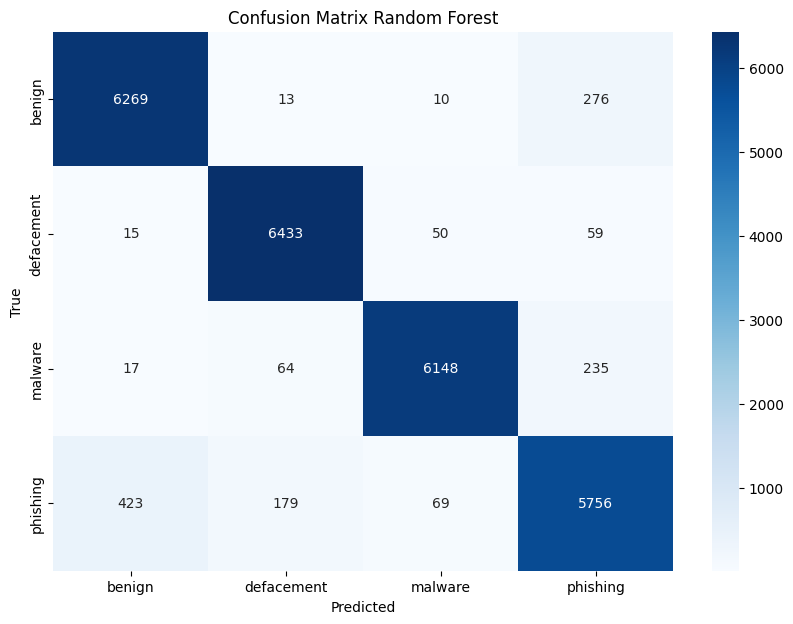

In [483]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labelEncoder.classes_,  # Ako koristiš LabelEncoder
            yticklabels=labelEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Random Forest')
plt.show()

<Axes: >

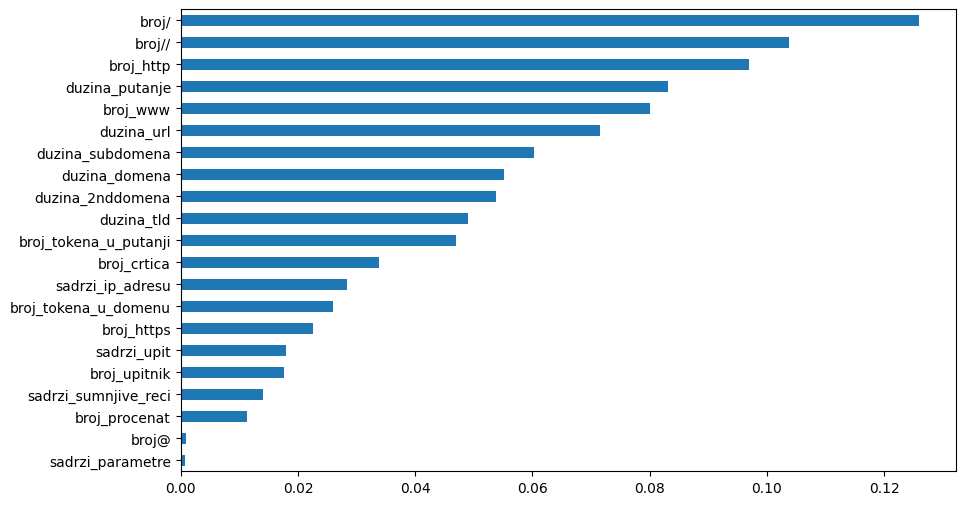

In [484]:
vaznost_atributa = pd.Series(rf.feature_importances_, index=X_train.columns)
vaznost_atributa.sort_values().plot(kind="barh",figsize=(10, 6))